## A gentle practical intro to adversarial ML using pytorch and cleverhans

FOM Seminars, by D. Rios, V. Gallego, R. Naveiro, D. Banks, J. Ríos, J. González, F. Ruggeri, C. Joshi, R. Soyer.


* Pytorch https://pytorch.org/ is a popular deep learning framework with GPU support.
* cleverhans https://github.com/tensorflow/cleverhans is an adversarial example library for constructing attacks, building defenses, and benchmarking both.

In [1]:
# First, we load the necessary libraries

import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.python.platform import flags
from torch.autograd import Variable
from torchvision import datasets, transforms

from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf

/home/victor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
# We define some hyperparameters

n_epochs = 6
batch_size = 128
lr = .001

We will define our model, a basic CNN classifier

In [3]:
class SimpleCNN(nn.Module):
    """ Basic MNIST model from github
    https://github.com/rickiepark/pytorch-examples/blob/master/mnist.ipynb
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 7 * 7)  # reshape Variable
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

We may take a look at its architecture, which consists in 2 convolutional layers and 2 linear layers

In [4]:
cnn = SimpleCNN()
cnn

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

Just for clarity, with the help of https://github.com/szagoruyko/pytorchviz we will visualize the net

In [5]:
from torchviz import make_dot

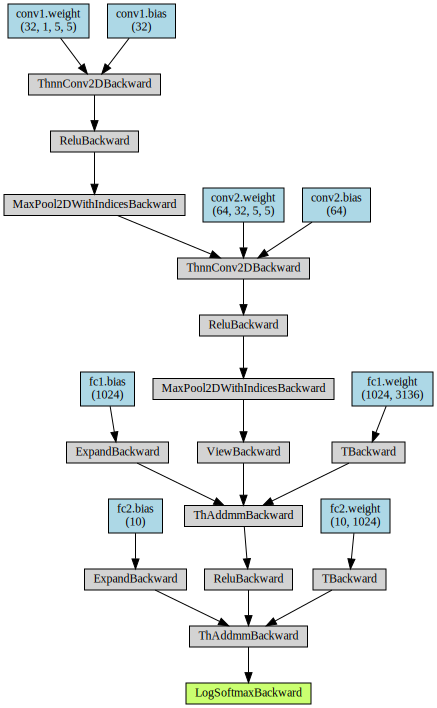

In [12]:
random_input = torch.randn([1, 1, 28, 28])

make_dot(cnn(random_input), params=dict(cnn.named_parameters()))

In [21]:
# Check for GPU and load the MNIST dataset
torch_model = SimpleCNN()
if torch.cuda.is_available():
    torch_model = torch_model.cuda()
report = AccuracyReport()

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size)

# Truncate the datasets so that our test run more quickly
train_end=-1
test_end=-1
train_loader.dataset.train_data = train_loader.dataset.train_data[:train_end]
test_loader.dataset.test_data = test_loader.dataset.test_data[:test_end]

We are now ready to train the model. We will use the Adam optimizer, a popular variant of stochastic gradient descent

In [ ]:
# Train our model
optimizer = optim.Adam(torch_model.parameters(), lr=lr)
train_loss = []

total = 0
correct = 0
step = 0
for epoch in range(n_epochs):
    for xs, ys in train_loader:
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients

        preds_np = preds.data.cpu().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys).sum()
        total += len(xs)
        step += 1
        if total % 1000 == 0:
            acc = float(correct) / total
            print('[%s] Training accuracy: %.2f%%' % (step, acc * 100))
            total = 0
            correct = 0

In [100]:
# Evaluate on clean data
total = 0
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    if torch.cuda.is_available():
        xs, ys = xs.cuda(), ys.cuda()

    preds = torch_model(xs)
    preds_np = preds.data.cpu().numpy()

    correct += (np.argmax(preds_np, axis=1) == ys).sum()
    total += len(xs)

acc = float(correct) / total
report.clean_train_clean_eval = acc
print('[%s] Clean accuracy: %.2f%%' % (step, acc * 100))

[1203] Clean accuracy: 99.02%


In [25]:
# We use tf for evaluation on adversarial data
sess = tf.Session()
x_op = tf.placeholder(tf.float32, shape=(None, 1, 28, 28,))

# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_model_fn = convert_pytorch_model_to_tf(torch_model)
cleverhans_model = CallableModelWrapper(tf_model_fn, output_layer='logits')

Now, we will turn to perform the fast gradient sign method attack (FGSM), one of the first succesful attacks against deep neural networks. It was introduced by Goodfellow et al in 2014 https://arxiv.org/abs/1412.6572

The main idea is to slightly perturb an original sample $x$ following the sign of the gradient of the loss function $\mathcal{L}$:

$$
x' = x + \epsilon \mbox{sign}(\nabla_x \mathcal{L}(x,y,\theta))
$$

In [143]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.1}
adv_x_op = fgsm_op.generate(x_op, **fgsm_params)
adv_preds_op = tf_model_fn(adv_x_op)

In [144]:
# Run an evaluation of our model against fgsm
total = 0
correct = 0
for xs, ys in test_loader:
    adv_preds = sess.run(adv_preds_op, feed_dict={x_op: xs})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    total += len(xs)

acc = float(correct) / total
print('Adv accuracy: {:.3f} %'.format(acc * 100))

Adv accuracy: 60.886 %


As we can see, the performance of our neural classified is severely degraded after we attacked the test set:
from 99% to 60% of accuracy.

We will grab a single test example and see it with more detail

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt

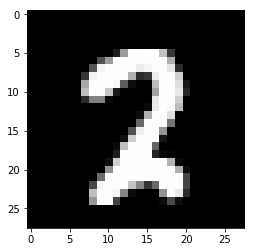

In [162]:
idx = 1
sample = xs[idx]
plt.imshow(sample.numpy()[0,:,:], cmap='gray')

In [163]:
sample.requires_grad = True
output = torch_model(sample.unsqueeze(0))
torch.argmax( output  )

tensor(2)

Seems that the previous example was correctly classified. Let's see what happens under the FGSM attack

In [164]:
# We backpropagate through the net
F.nll_loss(output, ys[idx].unsqueeze(0)).backward()

Now, we have computed the quantity of interest $\nabla_x \mathcal{L}(x,y,\theta)$:

In [171]:
sample.grad.shape

torch.Size([1, 28, 28])

We manually perform the FGSM attack:

In [166]:
adv_sample = sample + 0.1*torch.sign(sample.grad)

In [167]:
adv_output = torch_model(adv_sample.unsqueeze(0))
torch.argmax(adv_output)

tensor(7)

Seems we have fooled our classifier again.. What's the visual aspect of our malicious input?

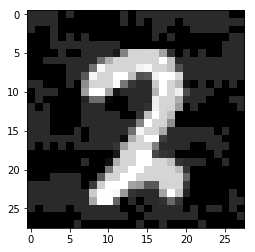

In [168]:
plt.imshow(adv_sample.detach().numpy()[0,:,:], cmap='gray')

To our eyes, that doesnt' look like a 7..

In [169]:
## TODO: something about Bayesian NN to test robustness against the adversarial perturbations?

In [170]:
## TODO: ACRA with spam example?